In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define custom metrics
def iou_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def dice_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1e-7) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

# Define U-Net model
def unet_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder (Contracting Path)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder (Expansive Path)
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Load dataset
def load_dataset(base_path):
    images = []
    masks = []

    for folder in range(1, 214):
        if folder==181:
            continue
        folder_name = f'{folder:03d}'
        folder_path = os.path.join(base_path, folder_name)

        if not os.path.exists(folder_path):
            continue

        img_folder = os.path.join(folder_path, 'images')
        mask_folder = os.path.join(folder_path, 'masks')

        for img_file in os.listdir(img_folder):
            if img_file.endswith('.bmp'):
                img_path = os.path.join(img_folder, img_file)
                mask_path = os.path.join(mask_folder, img_file.replace('.bmp', '.png'))

                image = load_img(img_path, target_size=(256, 256))
                mask = load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
                image = img_to_array(image) / 255.0
                mask = img_to_array(mask) / 255.0

                images.append(image)
                masks.append(mask)

    return np.array(images), np.array(masks)

# Train model
def train_model():
    X, y = load_dataset('/kaggle/input/iitd-iris-dataset/Masks and Images')

    if len(X) < 5:
        raise ValueError(f"Not enough samples for training. Found {len(X)} samples.")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = unet_model(input_shape=(256, 256, 3))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_score, dice_score])

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=8,
        epochs=50,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint('unet_trained.keras', save_best_only=True),
            tf.keras.callbacks.EarlyStopping(patience=10)
        ]
    )

    plot_training_history(history)
    visualize_predictions(model, X_val, y_val)

# Call the training function
if __name__ == "__main__":
    train_model()


Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 214s 748ms/step - accuracy: 0.7681 - dice_score: 0.3066 - iou_score: 0.2410 - loss: 0.4408 - val_accuracy: 0.9161 - val_dice_score: 0.8485 - val_iou_score: 0.7385 - val_loss: 0.2092
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 121s 575ms/step - accuracy: 0.9207 - dice_score: 0.8594 - iou_score: 0.7554 - loss: 0.1979 - val_accuracy: 0.9370 - val_dice_score: 0.8893 - val_iou_score: 0.8029 - val_loss: 0.1702
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 121s 574ms/step - accuracy: 0.9352 - dice_score: 0.8871 - iou_score: 0.8008 - loss: 0.1726 - val_accuracy: 0.9465 - val_dice_score: 0.9095 - val_iou_score: 0.8363 - val_loss: 0.1414
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 120s 573ms/step - accuracy: 0.9445 - dice_score: 0.9060 - iou_score: 0.8305 - loss: 0.1490 - val_accuracy: 0.9488 - val_dice_score: 0.9137 - val_iou_score: 0.8436 - val_loss: 0.1374
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 118s 562ms/step - accuracy: 0.9432 - dice_score: 0.9018 - iou_score: 0.8

NameError: name 'plot_training_history' is not defined

Epoch 1/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 203s 709ms/step - accuracy: 0.7809 - dice_score: 0.3062 - iou_score: 0.2446 - loss: 1.3065 - val_accuracy: 0.9143 - val_dice_score: 0.8412 - val_iou_score: 0.7274 - val_loss: 0.2080
Epoch 2/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 118s 563ms/step - accuracy: 0.9180 - dice_score: 0.8533 - iou_score: 0.7464 - loss: 0.2023 - val_accuracy: 0.9249 - val_dice_score: 0.8589 - val_iou_score: 0.7548 - val_loss: 0.1876
Epoch 3/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 118s 563ms/step - accuracy: 0.9330 - dice_score: 0.8846 - iou_score: 0.7955 - loss: 0.1732 - val_accuracy: 0.9465 - val_dice_score: 0.9097 - val_iou_score: 0.8365 - val_loss: 0.1403
Epoch 4/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 116s 551ms/step - accuracy: 0.9431 - dice_score: 0.9026 - iou_score: 0.8245 - loss: 0.1504 - val_accuracy: 0.9486 - val_dice_score: 0.9126 - val_iou_score: 0.8416 - val_loss: 0.1465
Epoch 5/50
210/210 ━━━━━━━━━━━━━━━━━━━━ 116s 550ms/step - accuracy: 0.9435 - dice_score: 0.9046 - iou_score: 0.8

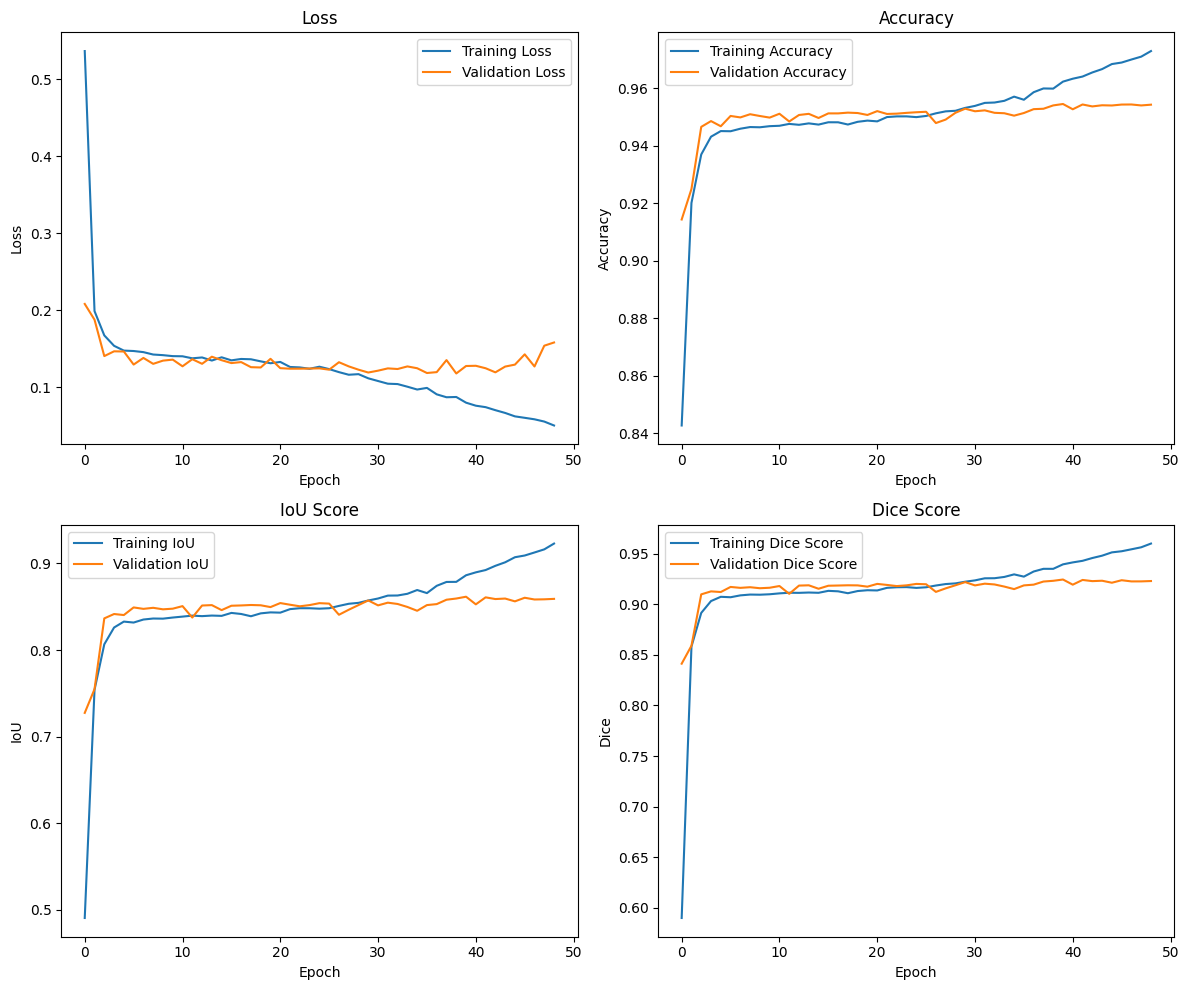

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


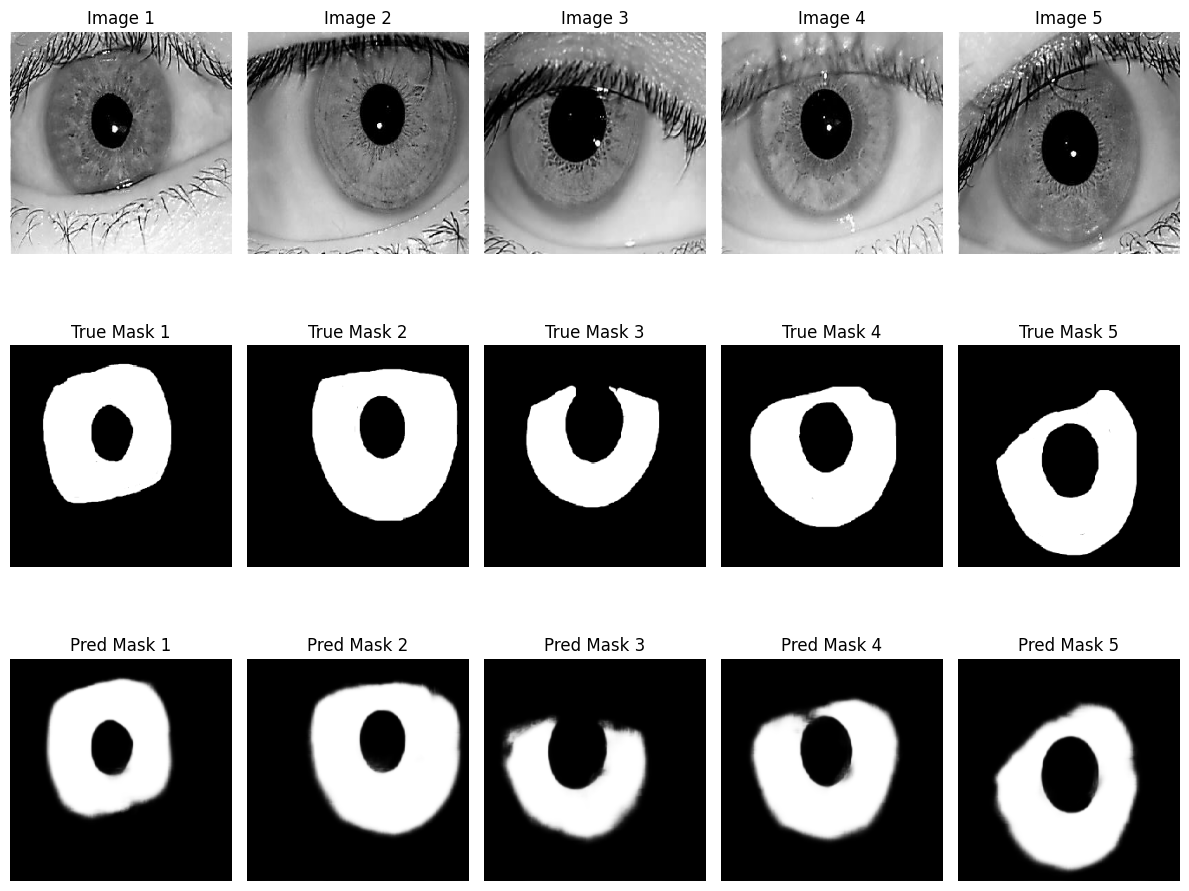

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define custom metrics
def iou_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

def dice_score(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + 1e-7) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + 1e-7)

# Define U-Net model
def unet_model(input_shape=(256, 256, 3), num_classes=1):
    inputs = Input(input_shape)

    # Encoder (Contracting Path)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder (Expansive Path)
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    outputs = Conv2D(num_classes, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Load dataset
def load_dataset(base_path):
    images = []
    masks = []

    for folder in range(1, 214):
        if folder==181:
            continue
        folder_name = f'{folder:03d}'
        folder_path = os.path.join(base_path, folder_name)

        if not os.path.exists(folder_path):
            continue

        img_folder = os.path.join(folder_path, 'images')
        mask_folder = os.path.join(folder_path, 'masks')

        for img_file in os.listdir(img_folder):
            if img_file.endswith('.bmp'):
                img_path = os.path.join(img_folder, img_file)
                mask_path = os.path.join(mask_folder, img_file.replace('.bmp', '.png'))

                image = load_img(img_path, target_size=(256, 256))
                mask = load_img(mask_path, target_size=(256, 256), color_mode='grayscale')
                image = img_to_array(image) / 255.0
                mask = img_to_array(mask) / 255.0

                images.append(image)
                masks.append(mask)

    return np.array(images), np.array(masks)

# Train model
def train_model():
    X, y = load_dataset('/kaggle/input/iitd-iris-dataset/Masks and Images')

    if len(X) < 5:
        raise ValueError(f"Not enough samples for training. Found {len(X)} samples.")

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    model = unet_model(input_shape=(256, 256, 3))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou_score, dice_score])

    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=8,
        epochs=50,
        callbacks=[
            tf.keras.callbacks.ModelCheckpoint('unet_trained.keras', save_best_only=True),
            tf.keras.callbacks.EarlyStopping(patience=10)
        ]
    )

    plot_training_history(history)
    visualize_predictions(model, X_val, y_val)













def plot_training_history(history):
    # Create separate plots for each metric
    metrics = ['loss', 'accuracy', 'iou_score', 'dice_score']
    titles = ['Loss', 'Accuracy', 'IoU Score', 'Dice Score']

    plt.figure(figsize=(12, 10))

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # IoU Score
    plt.subplot(2, 2, 3)
    plt.plot(history.history['iou_score'], label='Training IoU')
    plt.plot(history.history['val_iou_score'], label='Validation IoU')
    plt.title('IoU Score')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()

    # Dice Score
    plt.subplot(2, 2, 4)
    plt.plot(history.history['dice_score'], label='Training Dice Score')
    plt.plot(history.history['val_dice_score'], label='Validation Dice Score')
    plt.title('Dice Score')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, X_val, y_val):
    # Make predictions
    predictions = model.predict(X_val[:5])  # Predict on the first 5 images of the validation set

    # Plot original images, masks, and predictions
    plt.figure(figsize=(12, 10))

    for i in range(5):
        plt.subplot(3, 5, i + 1)
        plt.imshow(X_val[i])  # Original Image
        plt.title(f'Image {i+1}')
        plt.axis('off')

        plt.subplot(3, 5, i + 6)
        plt.imshow(y_val[i].squeeze(), cmap='gray')  # Ground truth mask
        plt.title(f'True Mask {i+1}')
        plt.axis('off')

        plt.subplot(3, 5, i + 11)
        plt.imshow(predictions[i].squeeze(), cmap='gray')  # Predicted mask
        plt.title(f'Pred Mask {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the training function
if __name__ == "__main__":
    train_model()